In [1]:
from sklearn.naive_bayes import GaussianNB
from pathlib import Path
import sklearn.model_selection as model_selection
from typing import Tuple
from collections import defaultdict
from sklearn.metrics import accuracy_score
import pandas as pd
from itertools import product
import pytest
from numpy import array
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


from xnb import XNB, NotFittedError
from xnb.enums import BWFunctionName, Kernel, Algorithm

# Cargar datos

## pendigits

In [2]:
def prepareData():
  train_data = pd.read_csv("../data/pendigits-tra.csv", header= None)
  test_data = pd.read_csv("../data/pendigits-tes.csv", header= None)
  #print(train_data.head())
  x_train = train_data.iloc[:, 0:16]
  y_train = train_data[16]
  train = pd.concat([x_train, y_train.rename("target")], axis=1)
  x_train = train.drop(columns=["target"])
  y_train = train["target"]
  x_test = test_data.iloc[:, 0:16]
  y_test = test_data[16]
  test = pd.concat([x_test, y_test.rename("target")], axis=1)
  x_test = test.drop(columns=["target"])
  y_test = test["target"]

  return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = prepareData()

## dataset generico

In [3]:
def load_dataset(
        file_path: Path,
        class_column: str = 'class',
        n_cols: int = 10,
        sep: str = ','
) -> Tuple[pd.DataFrame, pd.Series]:
  df = pd.read_csv(file_path, sep=sep).drop('samples', axis=1, errors='ignore')
  y = df[class_column]
  x = df.drop(class_column, axis=1)
  x = x[list(x.columns)[:n_cols]]
  return x, y

## glass

In [4]:
x, y = load_dataset(Path('../data/glass.csv'), class_column='Type')

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=0.20, random_state=0)

In [5]:
df = pd.read_csv(Path('../data/glass.csv'), sep=',').drop('samples', axis=1, errors='ignore')
df = df[df.Type.isin([3,5,6,7])]
y = df['Type']
x = df.drop('Type', axis=1)

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=0.20, random_state=0)

## iris

In [6]:
## Iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target' ] = iris.target
x = df.drop('target', axis=1)
y = df['target'].replace(
  to_replace= [0, 1, 2], value = ['setosa', 'versicolor', 'virginica']
)

x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=0.20, random_state=0)

## Dataset sintetico

In [7]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Fijar la semilla para reproducibilidad
np.random.seed(42)

# Parámetros básicos
n_samples = 1000
n_features = 10
n_classes = 4
n_informative = 8
n_redundant = 0
n_clusters_per_class = 1

# Generar datos iniciales
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    n_redundant=n_redundant,
    n_classes=n_classes,
    n_clusters_per_class=n_clusters_per_class,
    class_sep=1.0,  # Ajusta la separación general entre clases
    random_state=42
)

# Crear DataFrame inicial
columns = [f'Feature_{i+1}' for i in range(n_features)]
df = pd.DataFrame(X, columns=columns)
df['Target'] = y

# Introducir sesgos en las características por clase
for class_label in range(n_classes):
    # Identificar las filas correspondientes a la clase
    class_rows = df['Target'] == class_label
    
    # Seleccionar las columnas dominantes por sus nombres
    dominant_features = [f'Feature_{i+1}' for i in range(class_label * 2, (class_label + 1) * 2)]
    
    # Incrementar los valores en las columnas dominantes para esta clase
    df.loc[class_rows, dominant_features] += 5

# Mapear las etiquetas a nombres de clases
class_names = ['Class A', 'Class B', 'Class C', 'Class D']
df['Target'] = df['Target'].map({i: name for i, name in enumerate(class_names)})

df = df.reset_index()
x = df.drop(columns=["Target"])
y = df["Target"]
x_train, x_test, y_train, y_test = train_test_split(
  df[columns],       # Características (X)
  df['Target'],      # Variable objetivo (y)
  test_size=0.2,     # 20% de los datos para prueba
  random_state=42,   # Fijar semilla para reproducibilidad
  stratify=df['Target'] # Asegurar balance entre clases
)





## Dry Beans

In [8]:
df = pd.read_excel("../data/Dry_Bean_Dataset.xlsx")
x, y = df.drop(columns = ['Bean ID', 'Class']), df['Class']
x_train, x_test, y_train, y_test = train_test_split(
  x,       # Características (X)
  y,      # Variable objetivo (y)
  test_size=0.2,     # 20% de los datos para prueba
  random_state=42,   # Fijar semilla para reproducibilidad
  stratify=y # Asegurar balance entre clases
)

# Ejecutar XNB

In [9]:
xnb = XNB()
bw = xnb._calculate_bandwidth(
    x, y, BWFunctionName.HSILVERMAN, 50, set(y)
)

In [10]:
kde_list = xnb._calculate_kdes(
        x, y, Kernel.GAUSSIAN, Algorithm.AUTO, bw, 50, set(y)
)

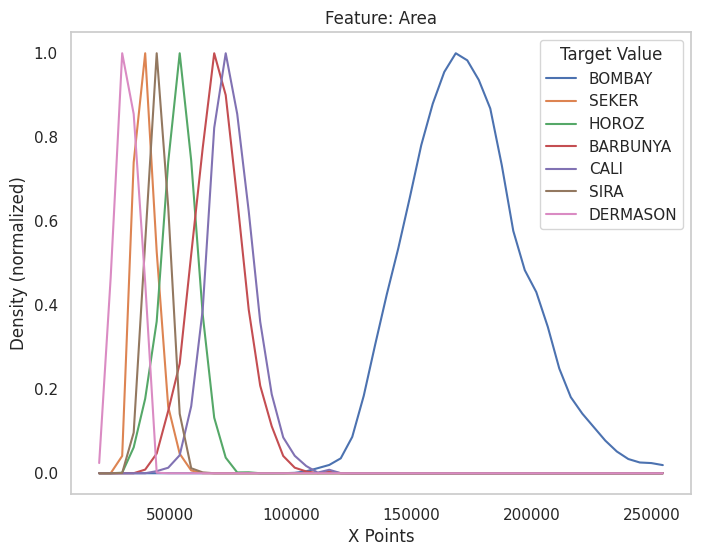

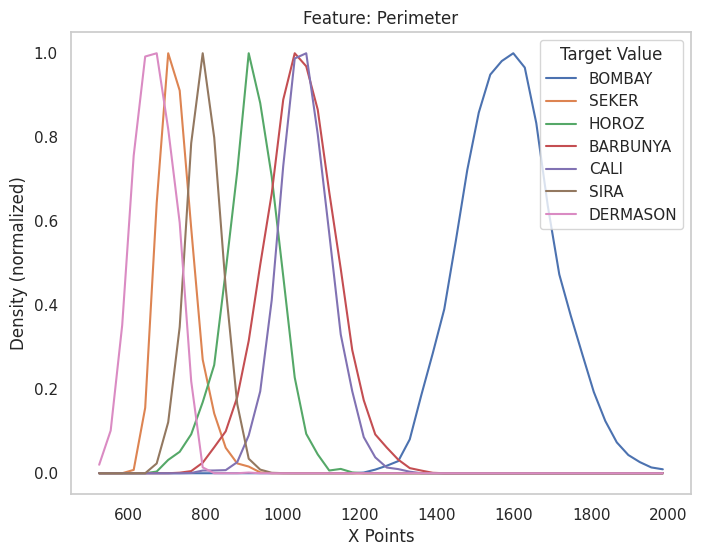

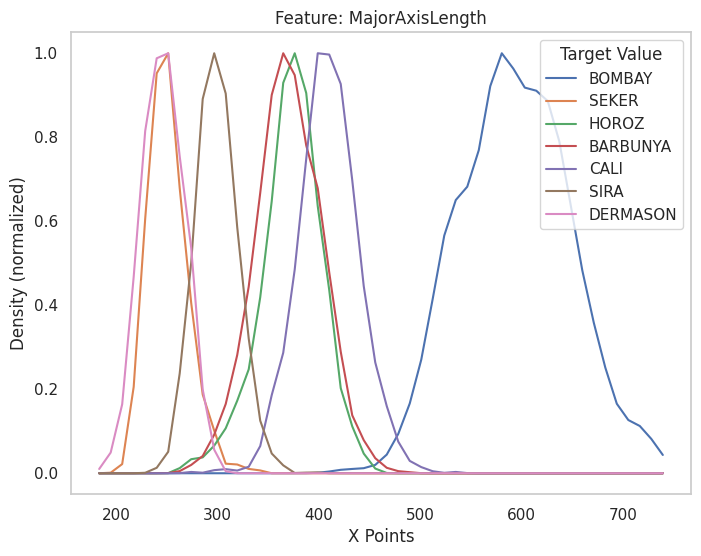

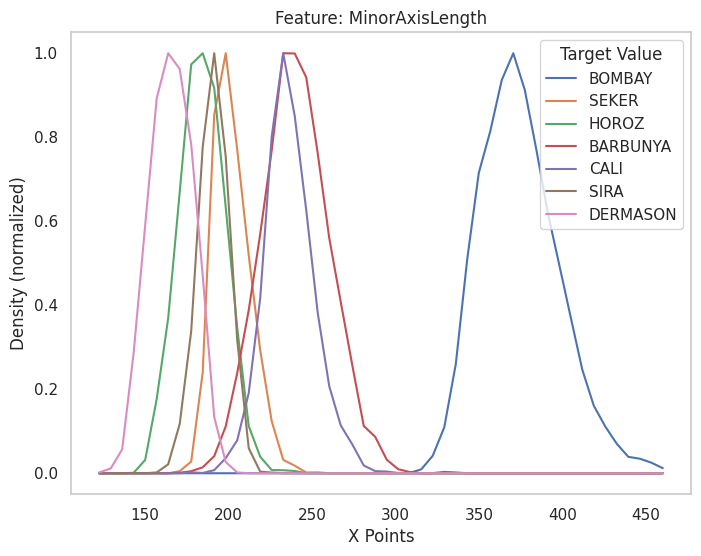

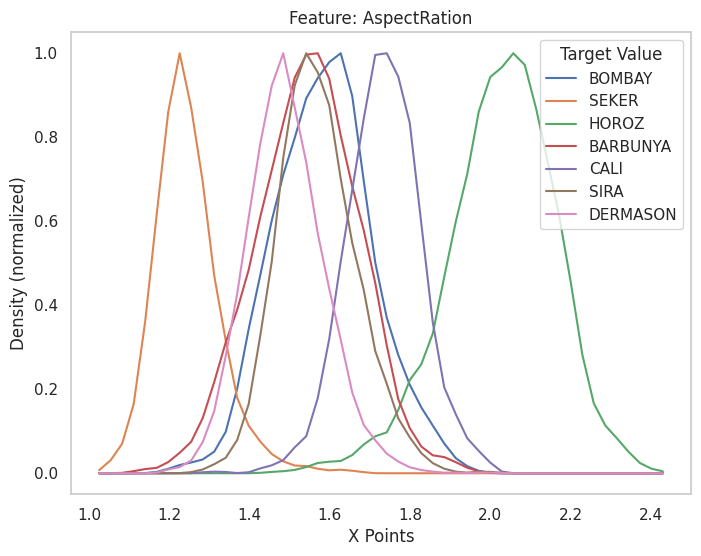

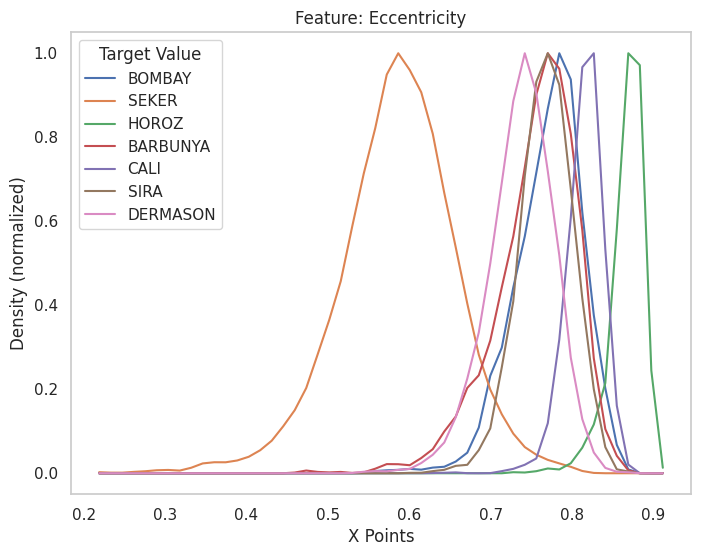

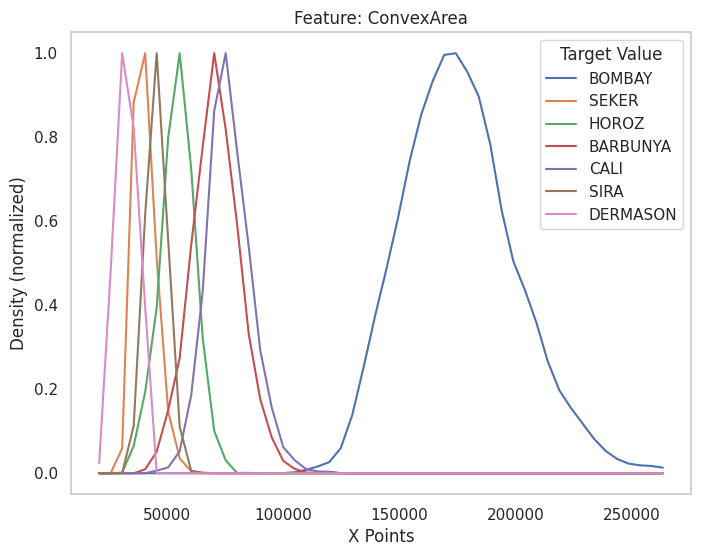

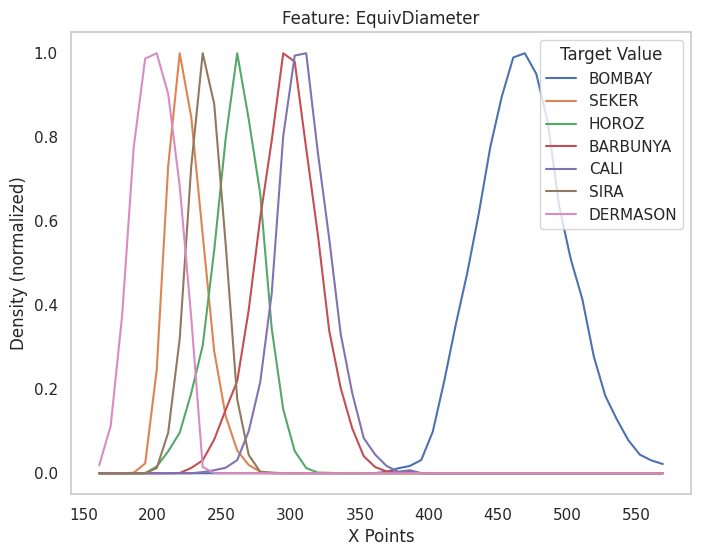

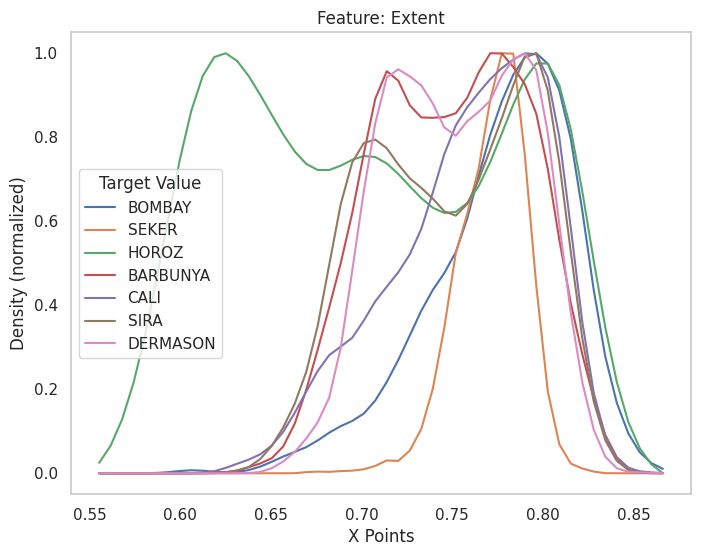

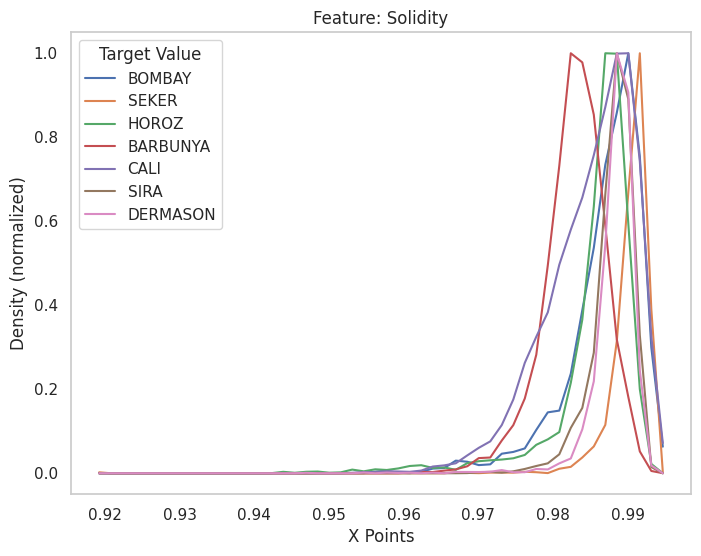

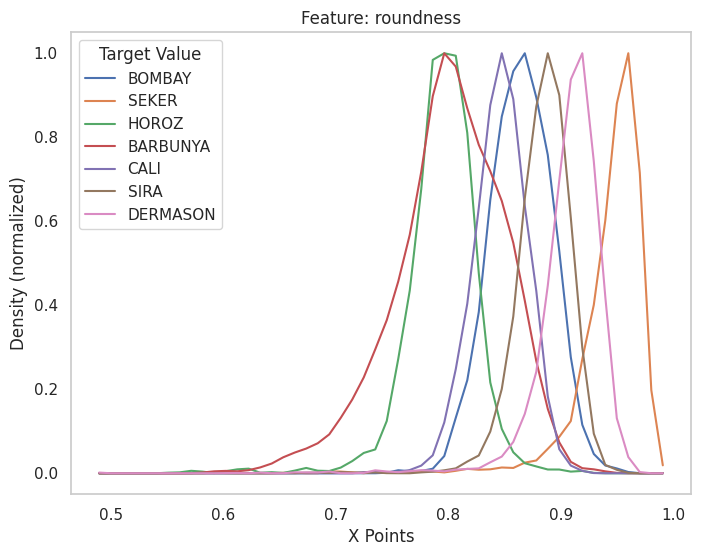

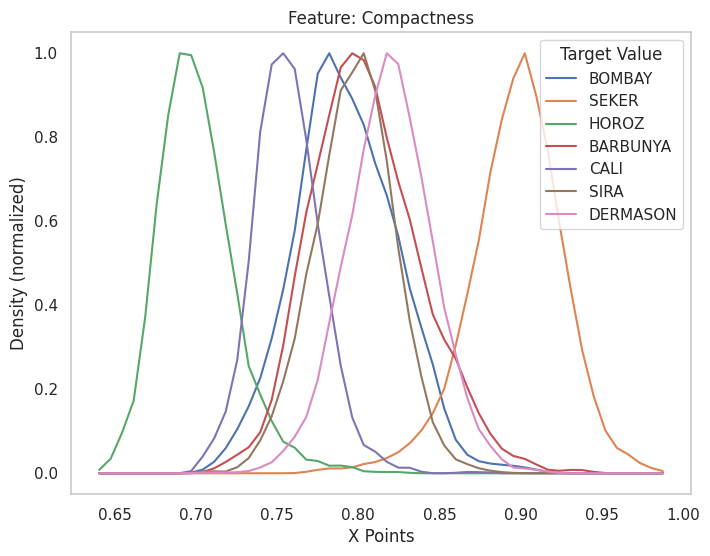

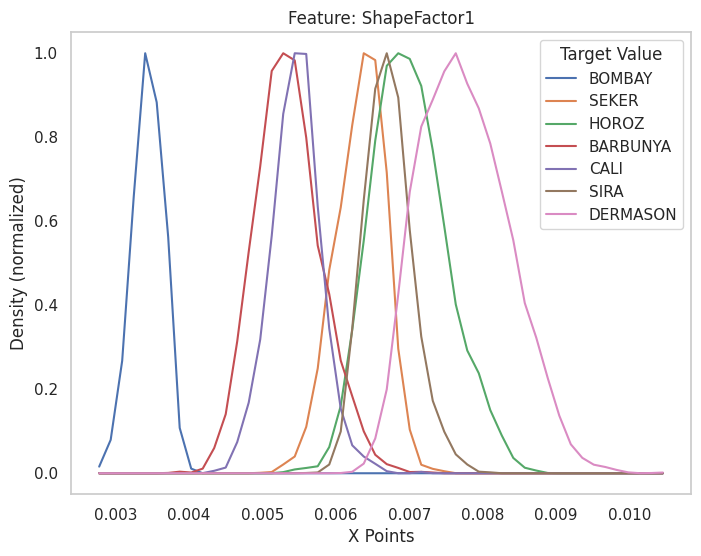

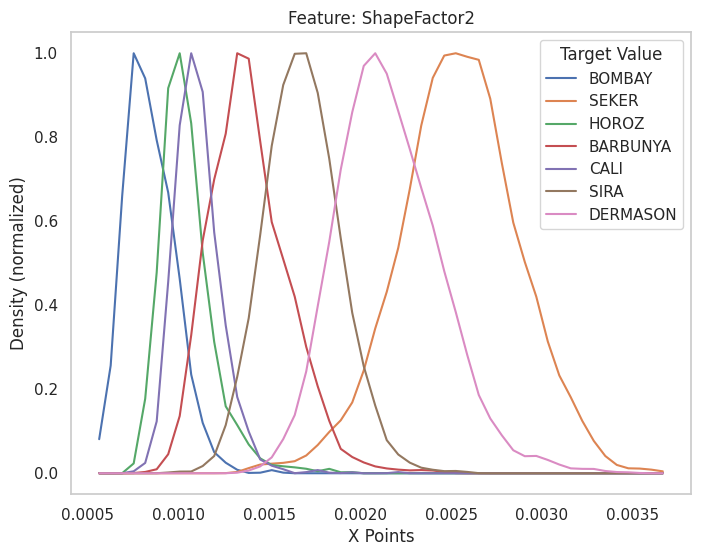

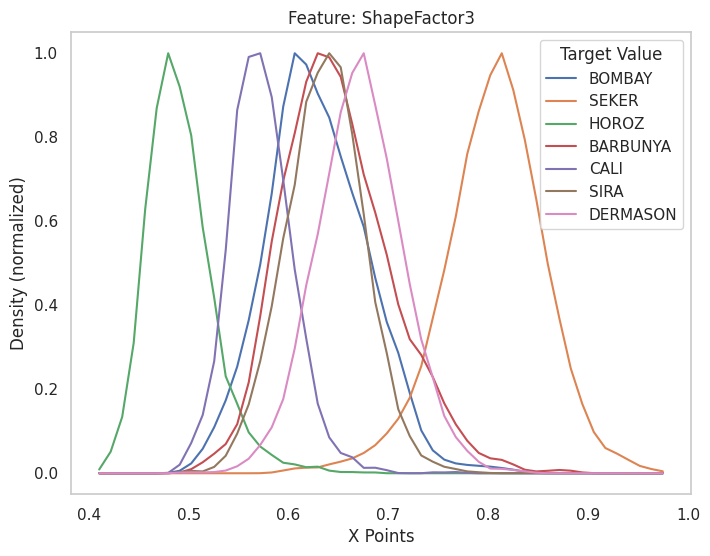

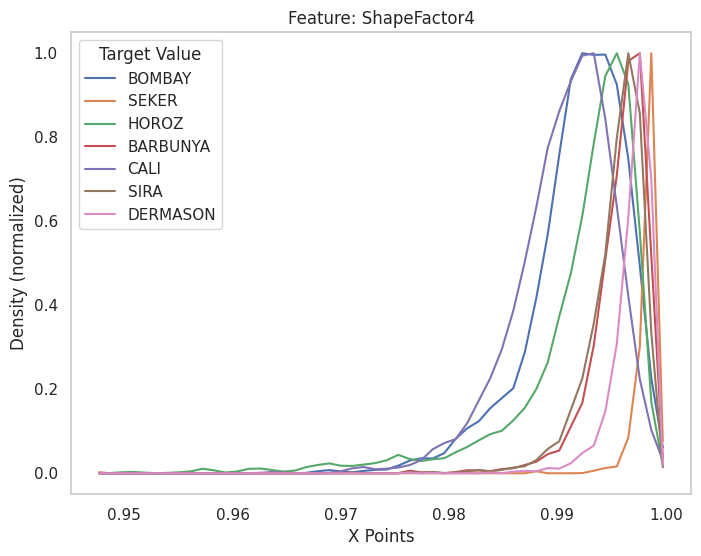

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

def plot_kde_objects_by_feature(kde_objects):
    """
    Función para graficar múltiples curvas de KDE organizadas por feature,
    con cada curva representando un target_value y normalización de y_points en el rango [0, 1].
    
    :param kde_objects: Lista de objetos KDE que contienen x_points, y_points, feature y target_value.
    """
    sns.set(style="whitegrid")
    
    # Organizar los objetos por feature
    feature_dict = defaultdict(list)
    for obj in kde_objects:
        feature_dict[obj.feature].append(obj)
    
    # Crear un gráfico para cada feature
    for feature, objects in feature_dict.items():
        plt.figure(figsize=(8, 6))
        
        # Graficar cada target_value dentro de la feature actual con normalización
        for obj in objects:
            # Normalizamos los datos de y_points para que estén en el rango [0, 1]
            y_min, y_max = np.min(obj.y_points), np.max(obj.y_points)
            y_normalized = (obj.y_points - y_min) / (y_max - y_min) if y_max > y_min else obj.y_points
            
            # Graficamos la serie normalizada
            plt.plot(obj.x_points, y_normalized, label=obj.target_value)
        
        # Configurar el título y las etiquetas
        plt.title(f'Feature: {feature}')
        plt.xlabel('X Points')
        plt.ylabel('Density (normalized)')
        plt.grid(False)
        
        # Agregar la leyenda para los target_values
        plt.legend(title='Target Value')
        
        # Mostrar el gráfico
        plt.show()

# Ejemplo de uso, reemplazando kde_list con tu lista de objetos KDE
plot_kde_objects_by_feature(kde_list)


In [12]:
ranking = xnb._calculate_divergence(kde_list)
xnb._calculate_feature_selection(ranking, set(y))

{'DERMASON': {'Area',
  'Compactness',
  'ConvexArea',
  'EquivDiameter',
  'MajorAxisLength',
  'MinorAxisLength',
  'Perimeter',
  'ShapeFactor1',
  'ShapeFactor2',
  'ShapeFactor3'},
 'BOMBAY': {'Area', 'EquivDiameter', 'MinorAxisLength', 'ShapeFactor1'},
 'SEKER': {'AspectRation',
  'Compactness',
  'ConvexArea',
  'Eccentricity',
  'EquivDiameter',
  'MajorAxisLength',
  'MinorAxisLength',
  'Perimeter',
  'ShapeFactor1',
  'ShapeFactor2',
  'ShapeFactor3'},
 'SIRA': {'Area',
  'AspectRation',
  'Compactness',
  'ConvexArea',
  'Eccentricity',
  'EquivDiameter',
  'MajorAxisLength',
  'MinorAxisLength',
  'Perimeter',
  'ShapeFactor1',
  'ShapeFactor3'},
 'HOROZ': {'AspectRation',
  'Compactness',
  'ConvexArea',
  'Eccentricity',
  'EquivDiameter',
  'MajorAxisLength',
  'MinorAxisLength',
  'Perimeter',
  'ShapeFactor1',
  'ShapeFactor2',
  'ShapeFactor3'},
 'CALI': {'Area',
  'AspectRation',
  'Compactness',
  'ConvexArea',
  'Eccentricity',
  'EquivDiameter',
  'MajorAxisLengt